# Mea Culpa on Partial Regression Plot

In [5]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [7]:
mpg.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,model_year,origin,name
0,18.0,8,307.0,130.0,3504,12.0,70,usa,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693,11.5,70,usa,buick skylark 320
2,18.0,8,318.0,150.0,3436,11.0,70,usa,plymouth satellite
3,16.0,8,304.0,150.0,3433,12.0,70,usa,amc rebel sst
4,17.0,8,302.0,140.0,3449,10.5,70,usa,ford torino


In [13]:
mpg = sns.load_dataset('mpg')
formula = 'weight ~ horsepower + cylinders + model_year'
model = smf.ols(formula=formula, data=mpg).fit()

In [14]:
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                 weight   R-squared:                       0.849
Model:                            OLS   Adj. R-squared:                  0.847
Method:                 Least Squares   F-statistic:                     724.8
Date:                Wed, 22 Jul 2020   Prob (F-statistic):          1.32e-158
Time:                        15:52:28   Log-Likelihood:                -2829.6
No. Observations:                 392   AIC:                             5667.
Df Residuals:                     388   BIC:                             5683.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -537.3542    405.181     -1.326      0.1

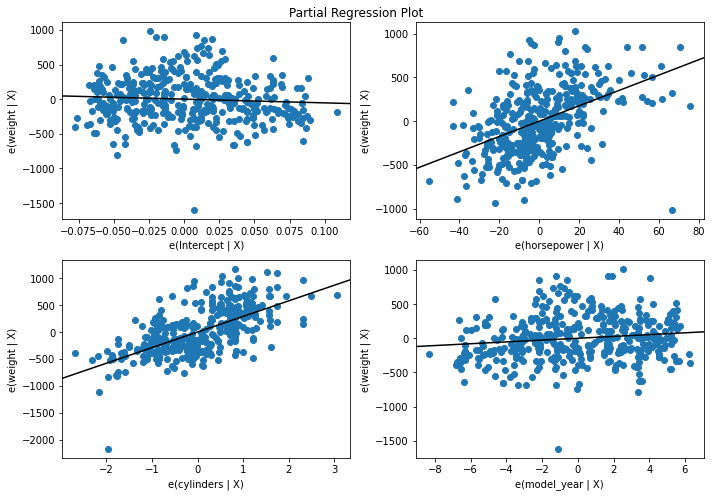

In [16]:
fig = plt.figure(figsize=(10,7))
fig = sm.graphics.plot_partregress_grid(model, fig=fig)

**How to read these graphs (top right, partial reg for `horsepower` for instance)**

- Each point is a car in our dataset


- Y value is the residual of the `predicted_weight`, by using all features except `horsepower` (i.e. using `cylinder`+`model_year`)

    - These residuals contain the remaining information about `weight` that couldn't be explained without `horespower`


- X value is the residual of the `predicted_horesepower`, by using all other features (i.e. using `cylinder`+`model_year`)
    - These residuals contain the new information that `horsepower` brings to the table, which is not already explained by the other features in the model.



# Improving Olist's Estimated Delivery Time (ETA)

Estimated Time Arrival (ETA) is a key component of modern e-commerce services. It allows to manage customer expectations by displaying a predicted date for customer delivery.

In this section we build a predictive model to improve Olist ETA prediction of orders `wait_time`, and compare it with Olist's `expected_wait_time`

## Load and check `orders` dataset

In [5]:
# Load all orders from our training_data

In [71]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [72]:
#import data
from olist.order import Order

In [73]:
orders = Order().get_training_data(with_distance_seller_customer=True)

In [74]:
orders.head(2)

,order_id,wait_time,expected_wait_time,delay_vs_expected,order_status,dim_is_five_star,dim_is_one_star,review_score,number_of_products,number_of_sellers,price,freight_value,distance_seller_customer
0,e481f51cbdc54678b7cc49136f2d6af7,8.436574,15.544063,0.0,delivered,0,0,4,1,1,29.99,8.72,18.063837
1,53cdb2fc8bc7dce0b6741e2150273451,13.782037,19.137766,0.0,delivered,0,0,4,1,1,118.70,22.76,856.292580


In [75]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 96525 entries, 0 to 96532
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   order_id                  96525 non-null  object 
 1   wait_time                 96525 non-null  float64
 2   expected_wait_time        96525 non-null  float64
 3   delay_vs_expected         96525 non-null  float64
 4   order_status              96525 non-null  object 
 5   dim_is_five_star          96525 non-null  int64  
 6   dim_is_one_star           96525 non-null  int64  
 7   review_score              96525 non-null  int64  
 8   number_of_products        96525 non-null  int64  
 9   number_of_sellers         96525 non-null  int64  
 10  price                     96525 non-null  float64
 11  freight_value             96525 non-null  float64
 12  distance_seller_customer  96525 non-null  float64
dtypes: float64(6), int64(5), object(2)
memory usage: 10.3+ MB


## Baseline Model - Olist’s current ETA model

❓ What's the baseline we want to optimize?

The delta between Olist' `expected_wait_time` and the real `wait_time`

Plot their respective histogram, median difference and RMSE

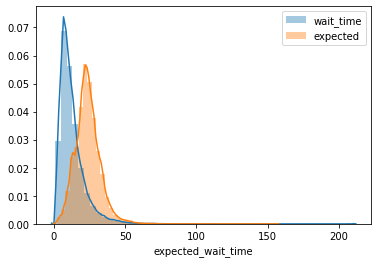

In [76]:
# Plot distribution
sns.distplot(orders.wait_time, label='wait_time')
sns.distplot(orders.expected_wait_time, label='expected')
plt.legend()

In [77]:
# Compute baseline RMSE (i.e 𝛔(error))
error = orders.expected_wait_time - orders.wait_time
RMSE_olist = ((error**2).mean())**0.5
RMSE_olist

15.13096685744435

## OLS multivariate model

Create an OLS model using the `statsmodel.api.OLS` method (not the `statsmodel.formula.api.ols`) this time

In [78]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

### prepare dataset of features X

In [79]:
# Create target variable y (Serie) and feature X (DataFrame) without data leaks!
y = orders.wait_time
y.shape

(96525,)

In [80]:
orders.columns

Index(['order_id', 'wait_time', 'expected_wait_time', 'delay_vs_expected',
       'order_status', 'dim_is_five_star', 'dim_is_one_star', 'review_score',
       'number_of_products', 'number_of_sellers', 'price', 'freight_value',
       'distance_seller_customer'],
      dtype='object')

In [81]:
#X.shape = (95525, 4)
X = orders[['price', 'freight_value', 'number_of_products', 'number_of_sellers', 'distance_seller_customer']].copy()
X

,price,freight_value,number_of_products,number_of_sellers,distance_seller_customer
0,29.99,8.72,1,1,18.063837
1,118.70,22.76,1,1,856.292580
2,159.90,19.22,1,1,514.130333
3,45.00,27.20,1,1,1822.800366
4,19.90,8.72,1,1,30.174037
...,...,...,...,...,...
96528,72.00,13.08,1,1,69.481037
96529,174.90,20.10,1,1,474.098245
96530,205.99,65.02,1,1,968.051192
96531,359.98,81.18,2,1,370.146853


In [82]:
# standardize (z-normalize --> (Xi - mu)/std()) each features of X to compare coefficients
for f in X.columns:
    mu = X[f].mean()
    sigma = X[f].std()
    X[f] = (X[f] - mu)/sigma

In [83]:
X

,price,freight_value,number_of_products,number_of_sellers,distance_seller_customer
0,-0.511860,-0.651997,-0.264004,-0.112813,-0.979467
1,-0.087278,-0.000604,-0.264004,-0.112813,0.428808
2,0.109912,-0.164844,-0.264004,-0.112813,-0.146045
3,-0.440019,0.205392,-0.264004,-0.112813,2.052600
4,-0.560153,-0.651997,-0.264004,-0.112813,-0.959121
...,...,...,...,...,...
96528,-0.310793,-0.449712,-0.264004,-0.112813,-0.893083
96529,0.181705,-0.124016,-0.264004,-0.112813,-0.213301
96530,0.330507,1.960071,-0.264004,-0.112813,0.616570
96531,1.067531,2.709822,1.586072,-0.112813,-0.387946


In [88]:
# Let's check how different is it from the "formula" from statsmodel
# Use patsy.dmatrix(formula, DataFrame)

#smf.ols(formula = 'wait_time ~ price + freight_value')
import patsy
patsy.dmatrix('price + freight_value', orders)

DesignMatrix with shape (96525, 3)
  Intercept    price  freight_value
          1    29.99           8.72
          1   118.70          22.76
          1   159.90          19.22
          1    45.00          27.20
          1    19.90           8.72
          1   147.90          27.36
          1    59.99          15.17
          1    19.90          16.05
          1   149.99          19.77
          1   198.00          61.06
          1    98.00          16.13
          1    31.90          18.23
          1    19.90          12.80
          1    38.25          16.11
          1   132.40          14.05
          1  1299.00          77.45
          1    27.99          15.10
          1    17.90          11.85
          1    76.00          16.97
          1   109.90           8.96
          1    79.99           8.91
          1     9.50           7.78
          1   129.99          57.58
          1    89.90          14.21
          1   109.90          15.53
          1   130.40         

In [89]:
# Conclude? --> Add an intercept to X
X['intercept'] = 1
X

,price,freight_value,number_of_products,number_of_sellers,distance_seller_customer,intercept
0,-0.511860,-0.651997,-0.264004,-0.112813,-0.979467,1
1,-0.087278,-0.000604,-0.264004,-0.112813,0.428808,1
2,0.109912,-0.164844,-0.264004,-0.112813,-0.146045,1
3,-0.440019,0.205392,-0.264004,-0.112813,2.052600,1
4,-0.560153,-0.651997,-0.264004,-0.112813,-0.959121,1
...,...,...,...,...,...,...
96528,-0.310793,-0.449712,-0.264004,-0.112813,-0.893083,1
96529,0.181705,-0.124016,-0.264004,-0.112813,-0.213301,1
96530,0.330507,1.960071,-0.264004,-0.112813,0.616570,1
96531,1.067531,2.709822,1.586072,-0.112813,-0.387946,1


### Run OLS with statsmodels

In [92]:
model = sm.OLS(y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.160
Model:                            OLS   Adj. R-squared:                  0.160
Method:                 Least Squares   F-statistic:                     3666.
Date:                Wed, 22 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:44:48   Log-Likelihood:            -3.4629e+05
No. Observations:               96525   AIC:                         6.926e+05
Df Residuals:                   96519   BIC:                         6.926e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
price                        0.0474      0.031      1.531      0.126      -0.013       0.108
freight_value                0.6506      0.036     17.892      0.000       0.579       0.722
number_of_products          -0.3148      0.033     -9.552      0.000      -0.379      -0.250
number_of_sellers           -0.3607      0.029    -12.275      0.000      -0.418      -0.303
distance_seller_customer     3.5358      0.030    117.020      0.000       3.477       3.595
intercept                   12.5553      0.028    445.983      0.000      12.500      12.610
==============================================================================
Omnibus:                    93067.183   Durbin-Watson:                   1.989
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10695196.220
Skew:                           4.395   Prob(JB):                         0.00
Kurtosis:                      53.813   Cond. No.                         2.18
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Check model performance

### Goodness of fit

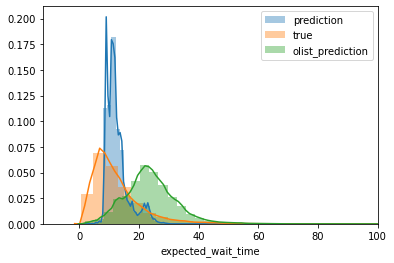

In [98]:
# Check prediction distributions
y_pred = model.predict(X)
y_true = orders.wait_time
y_olist = orders.expected_wait_time
y_pred.shape

sns.distplot(y_pred, label='prediction')
sns.distplot(y_true, label='true')
sns.distplot(y_olist, label='olist_prediction')
plt.xlim(xmax=100)
plt.legend()

In [101]:
# Compute RMSE (i.e 𝛔(residuals))
error = y_pred - y_true
((error**2).mean())**0.5

8.746087535851002

### Inferential conditions

❓ Check you ressiduals. Are they normally distributed?

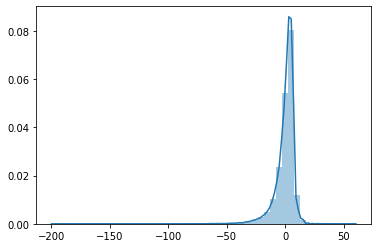

In [102]:
sns.distplot(error)

❓A more precise way to visualize normality is the [QQplot] (https://www.statsmodels.org/stable/generated/statsmodels.graphics.gofplots.qqplot.html). 
Plot the qqplot of your residual below, and make sure to understand the link with the histogram above.

Interpreting QQplots ([source](https://stats.stackexchange.com/questions/101274/how-to-interpret-a-qq-plot))
- dots are arranged on `y-axis` in ascending order of values (y-axis = residual values)
- dots are spaced on `x-axis` proportionally to a "normal distribution"

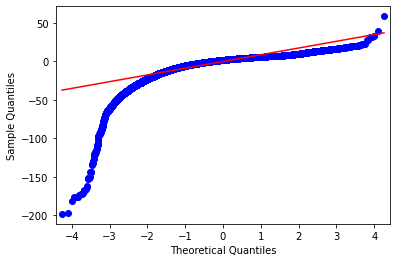

In [106]:
sm.qqplot(error, line='s');

#### QQ plot examples

In [120]:
# lets check QQ plots with our own distributions
from scipy import stats
stats.norm.rvs(0,1)

-1.4209070854113073

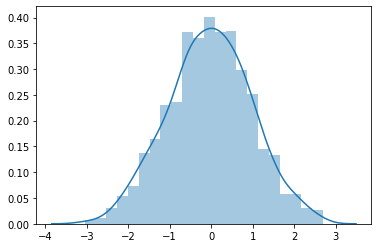

In [123]:
# Create & plot normal distributions
norm_list = [stats.norm.rvs(0,1) for x in range(1000)]
sns.distplot(norm_list)

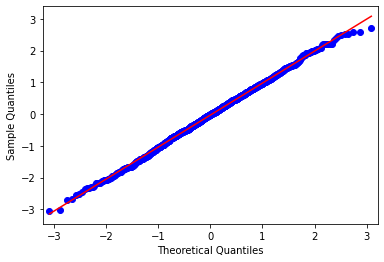

In [125]:
# Create and pliot bimodal distribution
sm.qqplot(np.array(norm_list), line='s');

#### Check residuals vs. fitted to see if we can detect any non-random pattern

## Can we add more Features? (Optional)

We add here additional features from the product details (size, category etc..)

### Add products details associated with each order (sum of product sizes, sum of weights etc...)

In [18]:
from olist.data import Olist
data = Olist().get_data()
products = data['products']
order_items = data['order_items']

In [19]:
order_items_products = (
    order_items.groupby(["order_id", "product_id"], as_index=False)
    .agg({"order_item_id": "count"})
    .rename(columns={"order_item_id": "order_item_count"})
    .merge(products.drop(["product_category_name"], axis=1), on="product_id")
)
order_items_products

,order_id,product_id,order_item_count,product_name_length,product_description_length,product_photos_qty,product_weight_g,product_length_cm,product_height_cm,product_width_cm
0,00010242fe8c5a6d1ba2dd792cb16214,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
1,130898c0987d1801452a8ed92a670612,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
2,532ed5e14e24ae1f0d735b91524b98b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
3,6f8c31653edb8c83e1a739408b5ff750,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
4,7d19f4ef4d04461989632411b7e588b9,4244733e06e7ecb4970a6e2683c13e61,1,58.0,598.0,4.0,650.0,28.0,9.0,14.0
...,...,...,...,...,...,...,...,...,...,...
102420,ffebd80e3291e811c308365936897efd,4cc4d02efc8f249c13355147fb44e34d,1,37.0,653.0,1.0,6700.0,35.0,12.0,22.0
102421,ffee31fb4b5e35c9123608015637c495,b10ecf8e33aaaea419a9fa860ea80fb5,1,30.0,308.0,1.0,2300.0,37.0,30.0,20.0
102422,fff7c4452f050315db1b3f24d9df5fcd,dd469c03ad67e201bc2179ef077dcd48,1,33.0,658.0,3.0,400.0,19.0,9.0,15.0
102423,fffa82886406ccf10c7b4e35c4ff2788,bbe7651fef80287a816ead73f065fc4b,1,32.0,280.0,2.0,2700.0,60.0,15.0,15.0


In [20]:
order_items_products.nunique()

order_id                      98666
product_id                    32951
order_item_count                 16
product_name_length              66
product_description_length     2960
product_photos_qty               19
product_weight_g               2204
product_length_cm                99
product_height_cm               102
product_width_cm                 95
dtype: int64

In [21]:
order_items_features = order_items_products.groupby("order_id", as_index=False).agg(
    {
        "product_weight_g": "sum",
        "product_length_cm": "max",
        "product_height_cm": "max",
        "product_width_cm": "max",
    }).rename(columns={
        "product_weight_g": "product_weight_g_sum",
        "product_length_cm": "product_length_cm_max",
        "product_height_cm": "product_height_cm_max",
        "product_width_cm": "product_width_cm_max",
    })
order_items_features

,order_id,product_weight_g_sum,product_length_cm_max,product_height_cm_max,product_width_cm_max
0,00010242fe8c5a6d1ba2dd792cb16214,650.0,28.0,9.0,14.0
1,00018f77f2f0320c557190d7a144bdd3,30000.0,50.0,30.0,40.0
2,000229ec398224ef6ca0657da4fc703e,3050.0,33.0,13.0,33.0
3,00024acbcdf0a6daa1e931b038114c75,200.0,16.0,10.0,15.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,3750.0,35.0,40.0,30.0
...,...,...,...,...,...
98661,fffc94f6ce00a00581880bf54a75a037,10150.0,89.0,15.0,40.0
98662,fffcd46ef2263f404302a634eb57f7eb,8950.0,45.0,26.0,38.0
98663,fffce4705a9662cd70adb13d4a31832d,967.0,21.0,24.0,19.0
98664,fffe18544ffabc95dfada21779c9644f,100.0,20.0,20.0,20.0


In [22]:
orders2 = orders.merge(order_items_features, on="order_id", how="left").dropna()

### Run new OLS

In [28]:
X2 = orders2[[
        "number_of_products",
        "number_of_sellers",
        "price",
        "freight_value",
        "distance_seller_customer",
        "product_weight_g_sum",
        "product_length_cm_max",
        "product_height_cm_max",
        "product_width_cm_max"]].copy()
y2 = orders2["wait_time"].copy()

In [29]:
# standardize (z-normalize) each features of X to compare coefficients

for f in X2.columns:
    mu = X2[f].mean()
    sigma = X2[f].std()
    X2[f] = X2[f].map(lambda x: (x - mu) / sigma)

In [30]:
X2['constant'] = 1

In [34]:
model2 = sm.OLS(y2, X2).fit()

In [35]:
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              wait_time   R-squared:                       0.164
Model:                            OLS   Adj. R-squared:                  0.164
Method:                 Least Squares   F-statistic:                     2106.
Date:                Wed, 22 Jul 2020   Prob (F-statistic):               0.00
Time:                        17:07:38   Log-Likelihood:            -3.4597e+05
No. Observations:               96509   AIC:                         6.920e+05
Df Residuals:                   96499   BIC:                         6.920e+05
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
number_of_products          -0.1032      0.034     -2.991      0.003      -0.171      -0.036
number_of_sellers           -0.4006      0.029    -13.639      0.000      -0.458      -0.343
price                       -0.0328      0.031     -1.053      0.293      -0.094       0.028
freight_value                0.1399      0.044      3.177      0.001       0.054       0.226
distance_seller_customer     3.7097      0.031    118.330      0.000       3.648       3.771
product_weight_g_sum         0.4481      0.045      9.973      0.000       0.360       0.536
product_length_cm_max        0.3946      0.035     11.283      0.000       0.326       0.463
product_height_cm_max        0.2085      0.035      6.019      0.000       0.141       0.276
product_width_cm_max        -0.0650      0.036     -1.810      0.070      -0.135       0.005
constant                    12.5553      0.028    447.155      0.000      12.500      12.610
==============================================================================
Omnibus:                    93162.863   Durbin-Watson:                   1.990
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         10764031.420
Skew:                           4.403   Prob(JB):                         0.00
Kurtosis:                      53.983   Cond. No.                         3.56
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""